# Notebook for finding average number of FUTR (mid-century, RCP 8.5) severe hail days per year and differences between FUTR and HIST

### Import necessary libraries (xarray for resampling, cartopy for plotting)

In [1]:
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

## Import WRF mid-century FUTR (RCP 8.5) dataset. Contains 15 years of FUTR data (2040-2055) at daily intervals (12Z-12Z) for 366 Julian calendar days

In [2]:
ds = xr.open_dataset('/home/scratch/vgensini/mid_century_8p5_hail_resample.nc') #Open dataset containing 15 years of mid-century RCP 8.5 FUTR data

In [5]:
ds #Print out dataset- returns (5478, 899, 1399) array (daily data for 15 years plus 3 leap days) 

<xarray.Dataset>
Dimensions:     (Time: 5478, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2040-09-30T12:00:00 ... 2055-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

### Import netcdf file containing lat/lon coords for WRF files (use this for plotting later)

In [2]:
coords = xr.open_dataset('lat_lon.nc') #Open .nc file containing WRF lat/lon coords

### Assign lat/lon coords from file to variables

#### Lat/lon coords contained a third dimension equal to 1, we want to get rid of this and ensure data is 2D

In [3]:
lats = coords.CLAT.values[0, :, :]
lons = coords.CLONG.values[0, :, :]

### Resample WRF mid-FUTR data to find max daily (12Z-12Z) hail size for each day and grid cell

In [6]:
#ds_hail = ds.resample(Time = '24H', base = 12).max(dim = 'Time') #Use xarray's resample method to resample to daily max values

In [7]:
#ds_hail #Print out the dataset- should return (5479, 899, 1399) array- max daily data for 15 years (3 leap days) for each lat/lon grid cell

<xarray.Dataset>
Dimensions:     (Time: 5478, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2040-09-30T12:00:00 ... 2055-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0

### Save resampled max convective day dataset to netcdf

In [9]:
#ds_hail.to_netcdf('/home/scratch/jgoodin/mid_century_8p5_daily_max_hail_inches.nc') #Save .nc file to scratch directory

### Open dataset created above

In [4]:
ds_hail_daily_max = xr.open_dataset('/home/scratch/jgoodin/convective_daily_max_resamples/mid_century_8p5_daily_max_hail_inches.nc') #Open dataset created above- 
#saved to scratch directory

In [5]:
ds_hail_daily_max #Print out dataset- returns 5478 days

<xarray.Dataset>
Dimensions:     (Time: 5478, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2040-09-30T12:00:00 ... 2055-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

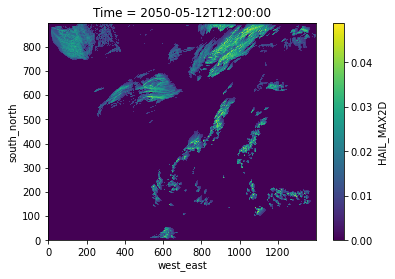

In [6]:
ds_hail_daily_max.sel(Time = '2050-05-12T12').HAIL_MAX2D.plot() #Test plot a day that we think has hail- make sure file contains data

### Identify grid cells (lat/lon coords) with values that meet severe threshold (≥ 1 in [0.0254 m in this case]), assign value of 1 to those that do, 0 to those that don't (not interested in these)

In [7]:
ds_sevr = 1 * (ds_hail_daily_max >= 0.0254) #Assign values of 1 to cells that meet sev criteria, assign days containing 1 cells as value of 1

In [8]:
ds_sevr #Print out sev results

<xarray.Dataset>
Dimensions:     (Time: 5478, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2040-09-30T12:00:00 ... 2055-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

## Repeat same process for HAIL_MAX2D ≥ 4 cm

In [9]:
ds_4cm = 1 * (ds_hail_daily_max >= 0.04) #Assign values of 1 to cells that meet >=4 cm criteria, assign days containing 1 cells as value of 1

In [10]:
ds_4cm #Also returns 5478 days

<xarray.Dataset>
Dimensions:     (Time: 5478, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2040-09-30T12:00:00 ... 2055-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

### Resample by year and sum along the 'Time' dimension- provides a count of annual severe hail days for each simulation year. Take mean along 'year' dimension to provide annual sev hail day count for total HIST period

In [9]:
sev_hail_days = ds_sevr.groupby('Time.year').sum(dim = 'Time').mean(dim = 'year') #Groupby year and sum sev days across time dim- take mean to find mean 
#sev hail days across mid-futr

In [10]:
sev_hail_days #Print out resample- should be 2D (899, 1399) and returns mean hist sev hail days

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

#### **Repeat above process for 4 cm HAIL_MAX2D

In [13]:
ds_4cm_hail_days = ds_4cm.groupby('Time.year').sum(dim = 'Time').mean(dim = 'year') #Groupby year and sum sev days across time dim- take mean to find mean 
#sev hail days across mid-futr

In [14]:
ds_4cm_hail_days

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

### Select HAIL_MAX2D variable from above dataset(s) to create a plottable data array

In [11]:
sev_hail_days = sev_hail_days.HAIL_MAX2D #**This is the plotting variable**

In [15]:
ds_4cm_hail_days = ds_4cm_hail_days.HAIL_MAX2D #**This is the plotting variable**

## Plot data on map of CONUS (change variable between severe [2.54 cm] and 4 cm)

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


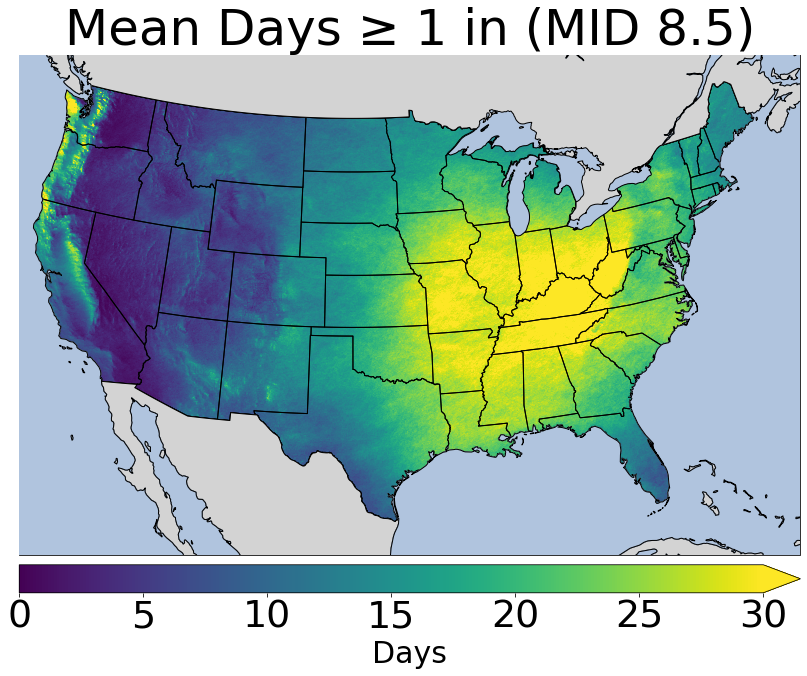

In [12]:
fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
lrFig = ax.pcolormesh(lons, lats, sev_hail_days, vmax = 30, cmap = 'viridis', transform = ccrs.PlateCarree())
#gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
#gls.top_labels=False
#gls.right_labels=False
#gls.xlabel_style = {'size': 30, 'rotation': 0}
#gls.xpadding = 12.0
#gls.ylabel_style = {'size': 30}
plt.title("Mean Days ≥ 1 in (MID 8.5)", fontsize = 50)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, ticks = [0, 5, 10, 15, 20, 25, 30], orientation = 'horizontal', extend = 'max')
cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 38)
plt.subplots_adjust(bottom=0.02)
plt.savefig('/home/scratch/jgoodin/sev_hail_day_climos/mid_century_8p5_annual_sev_hail_days_panel.png') #**Make sure to save results to png!**

# Subtract HIST from mid-FUTR (8.5) to get change in severe hail days

## Import dataset containing WRF HIST average annual severe hail days

In [13]:
hist_hail_days = xr.open_dataset('/home/scratch/jgoodin/sev_hail_day_climos/HIST/WRF_HIST_annual_sev_hail_days.nc') #Open dataset created in HIST sev hail day notebook

In [14]:
hist_hail_days #Print out dataset- should be 2D (899, 1399)

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float64 ...

## Import dataset containing WRF HIST average annual ≥ 4 cm hail days

In [19]:
hist_4cm_hail_days = xr.open_dataset('/home/scratch/jgoodin/WRF_HIST_annual_4cm_hail_days.nc') #Open >= 4 cm hail dataset created in HIST sev hail day notebook

In [20]:
hist_4cm_hail_days #Print out dataset

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float64 ...

### Select HAIL_MAX2D variable from above dataset(s) to create a plottable data array

In [15]:
hist_hail_days = hist_hail_days.HAIL_MAX2D

In [22]:
hist_4cm_hail_days = hist_4cm_hail_days.HAIL_MAX2D

## Subtract HIST annual hail days from mid-FUTR (8.5) annual hail days to get delta severe [and ≥ 4 cm] hail days

### Subtract variable(s) containing HIST hail days from variable containing FUTR hail days

In [16]:
delta_hail_days = sev_hail_days - hist_hail_days #**This is the plotting variable**

In [24]:
delta_4cm_hail_days = ds_4cm_hail_days - hist_4cm_hail_days #**This is the plotting variable**

## Plot on map of CONUS

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


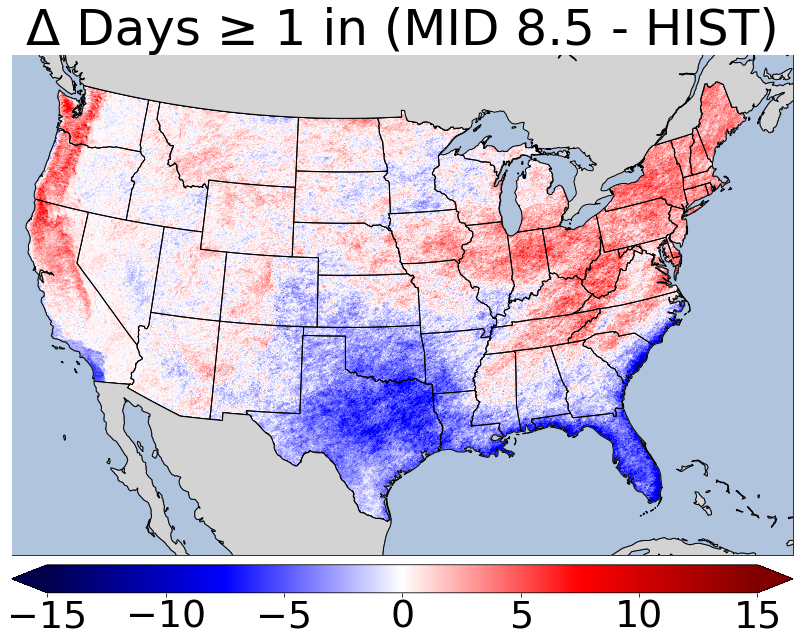

In [17]:
fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
lrFig = ax.pcolormesh(lons, lats, delta_hail_days, vmin = -15, vmax = 15, cmap = 'seismic', transform = ccrs.PlateCarree())
#gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
#gls.top_labels=False
#gls.right_labels=False
#gls.xlabel_style = {'size': 30, 'rotation': 0}
#gls.xpadding = 12.0
#gls.ylabel_style = {'size': 30}
plt.title("Δ Days ≥ 1 in (MID 8.5 - HIST)", fontsize = 50)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, ticks = [-15, -10, -5, 0, 5, 10, 15], orientation = 'horizontal', extend = 'both')
#cb.set_label(' Δ Days', fontsize = 30)
cb.ax.tick_params(labelsize = 38)
plt.subplots_adjust(bottom=0.02)
plt.savefig('/home/scratch/jgoodin/sev_hail_day_climos/delta_HIST_mid8p5_sev_hail_days_panel.png') #**Make sure to save results to png!**

# Find percent difference between WRF HIST and WRF mid-FUTR 8.5

### Calculate absolute value for numerator

In [18]:
abs_value_num = (sev_hail_days - hist_hail_days) #Use python's built-in abs function for absolute value

In [19]:
abs_value_num.shape

(899, 1399)

### Calculate percent difference

In [20]:
percent_diff = ((abs_value_num / (sev_hail_days + hist_hail_days) / 2)) * 100 #Calculate percent difference between WRF HIST and mid-FUTR 4.5

In [21]:
percent_diff.max()

<xarray.DataArray 'HAIL_MAX2D' ()>
array(50.)

## Read in numpy array containing results of Mann-Whitney U-test for statistical significance (with false discovery rate of alpha = 0.1)

### Results from Mann-Whitney will be hatched over plot of % difference

In [22]:
hist_mid8p5_utest = np.load('/home/scratch/jgoodin/fdr_delta_hist_mid8p5_annual_sev_hail_days.npy')

In [23]:
hist_mid8p5_utest

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

#### This is a quick way to check # of statistically significant grids at a 95% confidence level with alpha = 0.1

In [24]:
print(np.sum(hist_mid8p5_utest)) #This is an easy way to sum up # of 'True' grids (for booleans 0 = False and 1 = True)

88864


## Plot percent difference on map of CONUS

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'color', 'edgecolor', 'linewidth'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


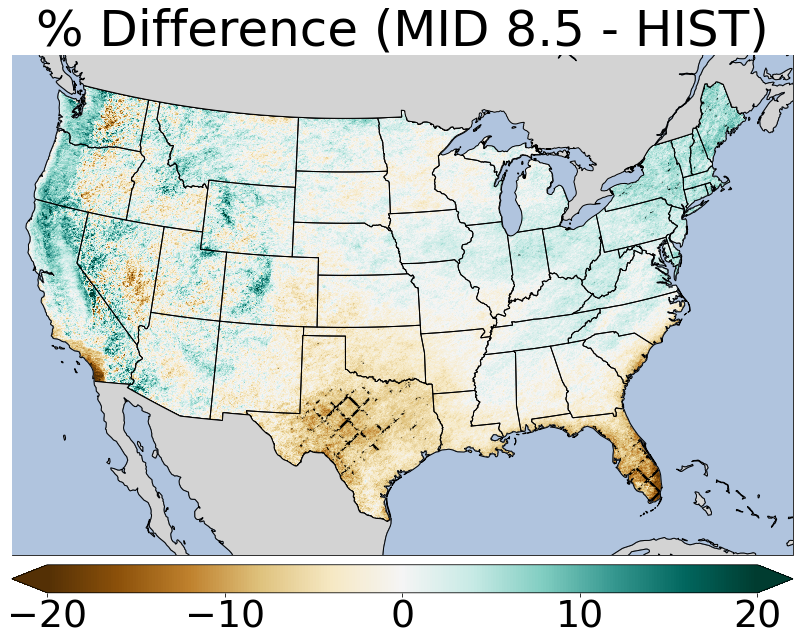

In [34]:
import matplotlib as mpl
fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
lrFig = ax.pcolormesh(lons, lats, percent_diff, vmin = -20, vmax = 20, cmap = 'BrBG', transform = ccrs.PlateCarree())
mpl.rcParams['hatch.linewidth'] = 2.5 #This changes the linewidth of the hatches
data = np.ma.masked_equal(hist_mid8p5_utest, 0) #Mask all values from Mann-Whitney array that are equal to 0 (False values)
ax.contourf(lons, lats, data, color = 'none', hatches = 'X', edgecolor = 'b', linewidth = 2, transform=ccrs.PlateCarree(), 
            alpha = 0) #Plot masked array and hatch over True values
#gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
#gls.top_labels=False
#gls.right_labels=False
#gls.xlabel_style = {'size': 30, 'rotation': 0}
#gls.xpadding = 12.0
#gls.ylabel_style = {'size': 30}
plt.title("% Difference (MID 8.5 - HIST)", fontsize = 50)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, ticks = [-20, -10, 0, 10, 20], orientation = 'horizontal', extend = 'both')
#cb.set_label(' Δ Days', fontsize = 30)
cb.ax.tick_params(labelsize = 38)
plt.subplots_adjust(bottom=0.02)
plt.savefig('/home/scratch/jgoodin/sev_hail_day_climos/HIST_mid8p5_sev_hail_percentdiff_panel.png') #**Make sure to save results to png!**